In [1]:
!pip install opendatasets --quiet
import opendatasets as od
od.download("https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: tanmay01bhatt
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/suchintikasarkar/sentiment-analysis-for-mental-health


100%|██████████| 11.1M/11.1M [00:00<00:00, 1.04GB/s]

In [2]:
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [3]:
data = pd.read_csv("/content/sentiment-analysis-for-mental-health/Combined Data.csv")
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
# Drop Unnamed column
data = data.drop(columns=['Unnamed: 0'])
data.dropna(inplace=True)

In [6]:
data.head()

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
data.shape

(52681, 2)

In [8]:
#Shortening the dataset
data = data.sample(n=9000,random_state=42).reset_index(drop=True)
data.shape

(9000, 2)

# Pre-Processing

In [9]:
import re
import nltk
from nltk.corpus import stopwords

In [10]:
nltk.download('stopwords')

# Get English stopwords from NLTK
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [11]:
def clean_text(statement):
    # Convert to lowercase
    statement = statement.lower()

    # Remove special characters (punctuation, non-alphabetic characters)
    statement = re.sub(r'[^\w\s]', '', statement)

    # Remove numbers (optional, depending on your use case)
    statement = re.sub(r'\d+', '', statement)

    # Tokenize the statement (split into words)
    words = statement.split()

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Rejoin words into a cleaned statement
    cleaned_statement = ' '.join(words)

    return cleaned_statement


In [12]:
# Apply the cleaning function to the 'statement' column
data['statement'] = data['statement'].apply(clean_text)

data

,statement,status
0,im lazy complain ba ihh,Normal
1,think wifi iphone broken quot connect quot act...,Normal
2,good tracking apps ive trying find apps track ...,Bipolar
3,recently looked reddit found place actually qu...,Depression
4,thats favorite thing,Normal
...,...,...
8995,,Normal
8996,late difficult months need someone talk listen...,Suicidal
8997,enough thr divided dont worry heart okay,Normal
8998,cats beautiful eyes,Normal


In [13]:
data['status'].value_counts()

,count
status,
Normal,2819
Depression,2605
Suicidal,1836
Anxiety,642
Bipolar,449
Stress,448
Personality disorder,201


# Imbalanced Classes

In [14]:
from imblearn.over_sampling import RandomOverSampler

In [15]:
ros = RandomOverSampler(sampling_strategy='auto', random_state=42)

In [16]:
X = data.drop(columns=['status'])
y = data['status']


In [17]:
# Perform oversampling
X_resampled, y_resampled = ros.fit_resample(X, y)


In [18]:
# Combine the oversampled features and target back into a DataFrame
data = pd.concat([X_resampled, y_resampled], axis=1)

In [19]:
data['status'].value_counts()

,count
status,
Normal,2819
Bipolar,2819
Depression,2819
Suicidal,2819
Stress,2819
Personality disorder,2819
Anxiety,2819


# Label Encoder

In [20]:
from sklearn.preprocessing import LabelEncoder

In [21]:
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['status'])

#Split

In [22]:
from sklearn.model_selection import train_test_split

In [23]:
x_train, x_test, y_train, y_test = train_test_split(data['statement'], data['label'], test_size=0.2)

In [24]:
max([len(text) for text in data['statement']])

16527

# Tokenization

In [25]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments

In [26]:
# Tokenization using BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [27]:
train_encodings = tokenizer(list(x_train), padding=True, truncation=True, max_length=200)
test_encodings = tokenizer(list(x_test), padding=True, truncation=True, max_length=200)

# Dataset

In [28]:
from torch.utils.data import DataLoader
from datasets import Dataset

In [29]:
train_dataset = Dataset.from_dict({'input_ids': train_encodings['input_ids'],
                                   'attention_mask': train_encodings['attention_mask'],
                                   'labels': y_train.tolist()})
test_dataset = Dataset.from_dict({'input_ids': test_encodings['input_ids'],
                                  'attention_mask': test_encodings['attention_mask'],
                                  'labels': y_test.tolist()})

In [30]:
train_dataset[0]

{'input_ids': [101,
  2691,
  2111,
  20704,
  17299,
  3374,
  5665,
  3046,
  2562,
  4659,
  2460,
  10047,
  2095,
  11614,
  3287,
  4921,
  2063,
  2196,
  11441,
  20704,
  17299,
  3752,
  8030,
  3204,
  3283,
  2477,
  2633,
  2081,
  3168,
  2552,
  3056,
  2126,
  2245,
  2785,
  2591,
  10089,
  2253,
  7242,
  2195,
  2086,
  3283,
  4921,
  2063,
  2371,
  2242,
  2842,
  2144,
  2318,
  3110,
  2367,
  2690,
  2082,
  4921,
  2063,
  9511,
  2111,
  24501,
  26029,
  5332,
  14454,
  7616,
  2579,
  5841,
  3262,
  4468,
  6970,
  28823,
  4807,
  2145,
  2485,
  2814,
  2307,
  2155,
  6513,
  2145,
  9075,
  2969,
  19565,
  13806,
  2894,
  2174,
  3046,
  2393,
  2111,
  7188,
  2356,
  3046,
  2092,
  16165,
  2157,
  4495,
  2147,
  2936,
  2783,
  3105,
  2453,
  2130,
  2131,
  4712,
  2086,
  2247,
  2240,
  2597,
  2071,
  10468,
  2907,
  2717,
  2551,
  2166,
  2052,
  7543,
  9125,
  2843,
  24501,
  26029,
  5332,
  14454,
  7616,
  4092,
  2178,
  2653,
 

# Model

In [31]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=len(label_encoder.classes_))

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [34]:
model = model.to(device)

In [35]:

training_args = TrainingArguments(
    output_dir="./results",          # Output directory for results
    eval_strategy="epoch",     # Evaluate once per epoch
    save_strategy="epoch",          # Save model at the end of each epoch to match evaluation strategy
    learning_rate=2e-5,              # Learning rate
    per_device_train_batch_size=16,  # Batch size for training
    per_device_eval_batch_size=16,   # Batch size for evaluation
    num_train_epochs=5,              # Increase number of epochs
    weight_decay=0.01,               # Strength of weight decay
    logging_dir="./logs",            # Directory for logging
    logging_steps=10,                # Log every 10 steps
    lr_scheduler_type="linear",      # Use linear learning rate scheduler with warmup
    warmup_steps=500,                # Number of warmup steps for learning rate scheduler
    load_best_model_at_end=True,     # Load the best model at the end of training
    metric_for_best_model="eval_loss", # Monitor eval loss to determine the best model
    save_total_limit=3,              # Limit the number of checkpoints to save
    gradient_accumulation_steps=2    # Simulate larger batch size if GPU memory is limited
)

In [36]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)


In [37]:
# Fine-tuning the model
trainer.train()

/usr/local/lib/python3.12/dist-packages/notebook/notebookapp.py:191: SyntaxWarning: invalid escape sequence '\/'
  | |_| | '_ \/ _` / _` |  _/ -_)
wandb: (1) Create a W&B account
wandb: (2) Use an existing W&B account
wandb: (3) Don't visualize my results
wandb: Enter your choice:

 3


wandb: You chose "Don't visualize my results"


Epoch,Training Loss,Validation Loss
1,0.621000,0.626005
2,0.297000,0.288161
3,0.169900,0.252144
4,0.142300,0.266821
5,0.049800,0.273630


TrainOutput(global_step=2470, training_loss=0.4197736587119006, metrics={'train_runtime': 2960.7789, 'train_samples_per_second': 26.659, 'train_steps_per_second': 0.834, 'total_flos': 8112612464100000.0, 'train_loss': 0.4197736587119006, 'epoch': 5.0})

# Model Evaluation

In [38]:
from sklearn.metrics import classification_report, confusion_matrix

                      precision    recall  f1-score   support

             Anxiety       0.97      0.99      0.98       544
             Bipolar       0.96      1.00      0.98       550
          Depression       0.86      0.63      0.72       579
              Normal       0.95      0.89      0.92       567
Personality disorder       0.99      1.00      1.00       560
              Stress       0.95      0.99      0.97       556
            Suicidal       0.74      0.89      0.81       591

            accuracy                           0.91      3947
           macro avg       0.92      0.91      0.91      3947
        weighted avg       0.91      0.91      0.91      3947



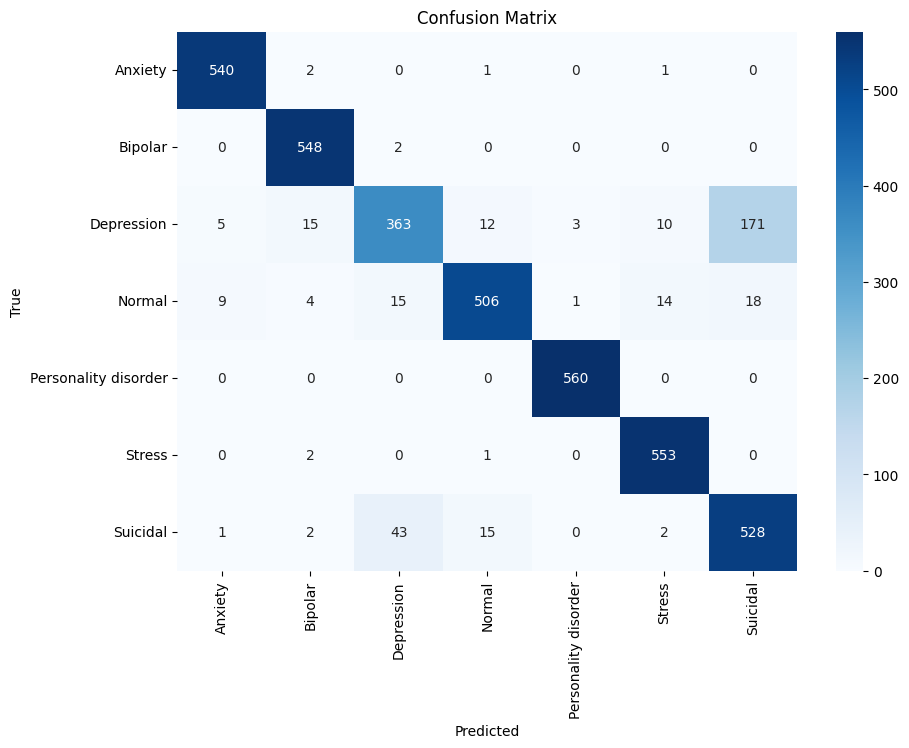

In [39]:
# Predictions
predictions, labels, _ = trainer.predict(test_dataset)

# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

# Classification Report
print(classification_report(y_test, predicted_labels, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test, predicted_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Inference

In [42]:
def detect_anxiety(text):
    cleaned_text = clean_text(text)
    inputs = tokenizer(cleaned_text, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=1).item()
    return label_encoder.inverse_transform([predicted_class])[0]

In [43]:
sample_texts = [
    "I feel perfectly fine today, nothing to worry about.",
    "I can't stop thinking about what will happen if things go wrong.",
    "Lately, I've been on a high, feeling like I can do anything!",
    "I'm so sad, I just can't seem to get out of bed anymore.",
    "I'm constantly thinking about how much better everyone else is doing than me.",
    "I don't think I can keep going, everything feels so hopeless.",
    "I had a really good day, spent some time with my friends.",
    "I'm overwhelmed by the idea that I might lose everything.",
    "I feel like nothing matters anymore, I just want to give up.",
    "I'm okay today, but sometimes I get really anxious for no reason."
]

# Assuming the detect_anxiety function is already defined and takes a sentence as input
for text in sample_texts:
    predicted_class = detect_anxiety(text)
    print(f"Sentence: {text}\nPredicted class: {predicted_class}\n")

Sentence: I feel perfectly fine today, nothing to worry about.
Predicted class: Anxiety

Sentence: I can't stop thinking about what will happen if things go wrong.
Predicted class: Normal

Sentence: Lately, I've been on a high, feeling like I can do anything!
Predicted class: Anxiety

Sentence: I'm so sad, I just can't seem to get out of bed anymore.
Predicted class: Normal

Sentence: I'm constantly thinking about how much better everyone else is doing than me.
Predicted class: Normal

Sentence: I don't think I can keep going, everything feels so hopeless.
Predicted class: Anxiety

Sentence: I had a really good day, spent some time with my friends.
Predicted class: Normal

Sentence: I'm overwhelmed by the idea that I might lose everything.
Predicted class: Suicidal

Sentence: I feel like nothing matters anymore, I just want to give up.
Predicted class: Suicidal

Sentence: I'm okay today, but sometimes I get really anxious for no reason.
Predicted class: Anxiety



# Saving Model

In [ ]:
# Save the trained model and tokenizer
trainer.save_model("saved_mental_status_bert")  # Save the model to the specified directory
tokenizer.save_pretrained("saved_mental_status_bert")  # Save the tokenizer


import pickle

pickle.dump(label_encoder, open('label_encoder.pkl', 'wb'))

In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

# Load the model and tokenizer from the saved paths
model = AutoModelForSequenceClassification.from_pretrained("saved_mental_status_bert")
tokenizer = AutoTokenizer.from_pretrained("saved_mental_status_bert")

label_encoder = pickle.load(open('label_encoder.pkl', 'rb'))